In [1]:
from splink.duckdb.duckdb_linker import DuckDBLinker
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
import pandas as pd 
pd.options.display.max_rows = 1000
df = pd.read_parquet("./data/historical_figures_with_errors_50k.parquet")
df.head(5)

,unique_id,cluster,full_name,first_and_surname,first_name,surname,dob,birth_place,postcode_fake,gender,occupation
0,Q2296770-1,Q2296770,"thomas clifford, 1st baron clifford of chudleigh",thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8df,male,politician
1,Q2296770-2,Q2296770,thomas of chudleigh,thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8df,male,politician
2,Q2296770-3,Q2296770,tom 1st baron clifford of chudleigh,tom chudleigh,tom,chudleigh,1630-08-01,devon,tq13 8df,male,politician
3,Q2296770-4,Q2296770,thomas 1st chudleigh,thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8hu,None,politician
4,Q2296770-5,Q2296770,"thomas clifford, 1st baron chudleigh",thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8df,None,politician


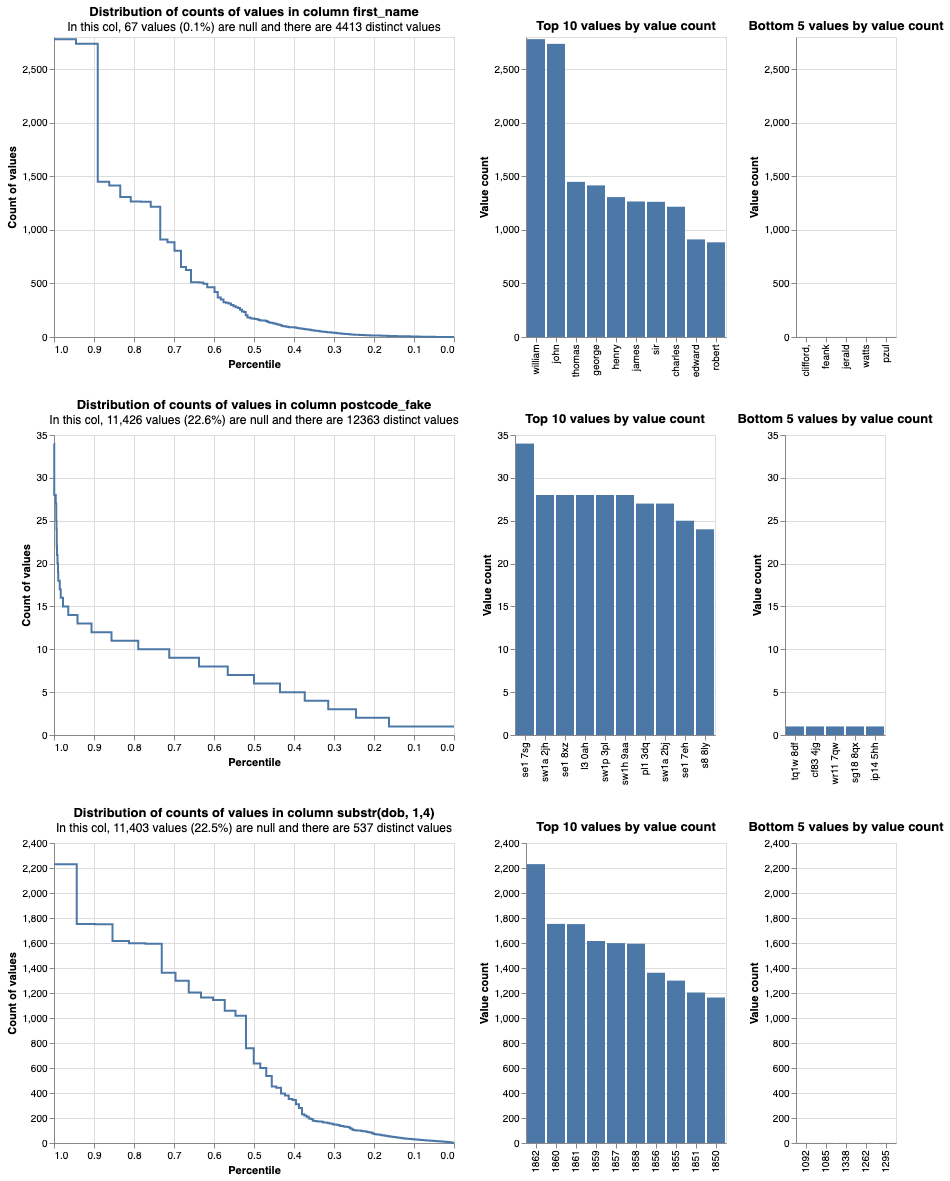

In [3]:
# Initialise the linker, passing in the input dataset(s)
settings = {"link_type": "dedupe_only"}
linker = DuckDBLinker(df, settings, connection=":temporary:")

import altair as alt
alt.renderers.enable('mimetype')
linker.profile_columns(["first_name", "postcode_fake", "substr(dob, 1,4)"], top_n=10, bottom_n=5)

In [4]:
linker.count_num_comparisons_from_blocking_rule("l.first_name = r.first_name")

16372982

In [5]:
linker.count_num_comparisons_from_blocking_rule("l.first_name = r.first_name and l.surname = r.surname")

243656

In [6]:
linker.count_num_comparisons_from_blocking_rule("l.dob = r.dob")

1549081

In [7]:
import splink.duckdb.duckdb_comparison_library as cl

settings = {
    "probability_two_random_records_match": 9/50_000,
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name and l.surname = r.surname",
        "l.surname = r.surname and l.dob = r.dob",
        "l.first_name = r.first_name and l.dob = r.dob",
        "l.postcode_fake = r.postcode_fake and l.first_name = r.first_name",
    ],
    "comparisons": [
        cl.jaccard_at_thresholds("first_name", [0.9, 0.5], term_frequency_adjustments=False),
        cl.jaccard_at_thresholds("surname", [0.9, 0.5], term_frequency_adjustments=False),
        cl.levenshtein_at_thresholds("dob", [1,2], term_frequency_adjustments=False),
        cl.levenshtein_at_thresholds("postcode_fake", 2),
        cl.exact_match("birth_place", term_frequency_adjustments=False),
        cl.exact_match("occupation",  term_frequency_adjustments=False),
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
    "max_iterations": 10,
    "em_convergence": 0.01
}

In [8]:
linker.initialise_settings(settings)

In [ ]:
linker.estimate_u_using_random_sampling(target_rows=5e6)

----- Estimating u probabilities using random sampling -----


In [ ]:
blocking_rule = "l.first_name = r.first_name and l.surname = r.surname"
training_session_names = linker.estimate_parameters_using_expectation_maximisation(blocking_rule)
training_session_names.match_weights_interactive_history_chart()

In [ ]:
blocking_rule = "l.dob = r.dob"
training_session_dob = linker.estimate_parameters_using_expectation_maximisation(blocking_rule)
training_session_dob.match_weights_interactive_history_chart()

The final match weights can be viewed in the match weights chart:

In [ ]:
linker.match_weights_chart()

In [ ]:
df_predict = linker.predict()
df_e = df_predict.as_pandas_dataframe(limit=5)
df_e

You can also view rows in this dataset as a waterfall chart as follows:

In [ ]:
from splink.charts import waterfall_chart
records_to_plot = df_e.to_dict(orient="records")
linker.waterfall_chart(records_to_plot, filter_nulls=False)

In [ ]:
clusters = linker.cluster_pairwise_predictions_at_threshold(df_predict, threshold_match_probability=0.95)

In [ ]:
linker.cluster_studio_dashboard(df_predict, clusters, "50k_cluster.html", sampling_method='by_cluster_size', overwrite=True)

In [ ]:
from IPython.display import IFrame

IFrame(
    src="./50k_cluster.html", width="100%", height=1200
)  